## Environment Setup and Dataset Preparation


In [ ]:
pip -q install torch torchvision transformers openai requests Pillow numpy scikit-learn matplotlib seaborn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Download and unzip dataset:

In [ ]:
import requests
import tarfile
import os

dataset_url = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar"
dataset_path = "/content/drive/MyDrive/CSCI2470/final/stanford_dogs_dataset"

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)
    print(f"Downloading Stanford Dogs dataset from {dataset_url}...")
    response = requests.get(dataset_url, stream=True)
    response.raise_for_status() # Raise an exception for bad status codes

    tar_file_path = os.path.join(dataset_path, "images.tar")
    with open(tar_file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete. Extracting...")

    with tarfile.open(tar_file_path, 'r') as tar:
        tar.extractall(path=dataset_path)
    print("Extraction complete.")
    os.remove(tar_file_path) # Clean up the tar file after extraction
else:
    print("Stanford Dogs dataset already downloaded and extracted.")

images_root = os.path.join(dataset_path, 'Images')
if not os.path.exists(images_root):
    print(f"Warning: 'Images' subdirectory not found in {dataset_path}. Please check dataset structure.")
else:
    print(f"Stanford Dogs images root directory: {images_root}")

Stanford Dogs dataset already downloaded and extracted.
Stanford Dogs images root directory: /content/drive/MyDrive/CSCI2470/final/stanford_dogs_dataset/Images


### Build dataset of (image, label) pairs:

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import os

class StanfordDogsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        for i, class_name in enumerate(sorted(os.listdir(root_dir))):
            if not class_name.startswith('n'): # Skip non-breed directories
                continue
            self.class_to_idx[class_name] = i
            self.idx_to_class[i] = class_name
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                self.image_paths.append(os.path.join(class_path, img_name))
                self.labels.append(i)

        print(f"Found {len(self.image_paths)} images belonging to {len(self.class_to_idx)} classes.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

### Load clip model, build embedding dataset:

In [ ]:
import torch
from transformers import CLIPProcessor, CLIPModel
from torch.utils.data import DataLoader
import logging

logging.getLogger("transformers").setLevel(logging.ERROR)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

clip_model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(clip_model_name)
clip_model = CLIPModel.from_pretrained(clip_model_name).to(device)
clip_model.eval()
print("CLIP ready")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

CLIP ready


In [ ]:
import os
import torch
from torch.utils.data import DataLoader

dataset = StanfordDogsDataset(root_dir=images_root, transform=None)

emb_dir = os.path.join(dataset_path, 'embeddings')
os.makedirs(emb_dir, exist_ok=True)
emb_path = os.path.join(emb_dir, 'clip_embeddings.pt')

if os.path.exists(emb_path):
    print(f"Embedding file {emb_path} already exists. Skipping generation.")
    data = torch.load(emb_path)
    embeddings = data["embeddings"]
    labels = data["labels"]
else:
    loader = DataLoader(
        dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        collate_fn=lambda batch: batch  # list of (image, label)
    )

    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            images, labels_batch = zip(*batch)
            inputs = processor(images=list(images), return_tensors="pt")
            inputs = {k: v.to(device) for k, v in inputs.items()}

            emb = clip_model.get_image_features(**inputs)
            emb = emb / emb.norm(dim=-1, keepdim=True)

            all_embeddings.append(emb.cpu())
            all_labels.append(torch.tensor(labels_batch))

    embeddings = torch.cat(all_embeddings)
    labels = torch.cat(all_labels)

    torch.save(
        {
            "embeddings": embeddings,
            "labels": labels
        },
        emb_path
    )
    print(f"Saved embeddings to {emb_path}")


Found 20580 images belonging to 120 classes.
Embedding file /content/drive/MyDrive/CSCI2470/final/stanford_dogs_dataset/embeddings/clip_embeddings.pt already exists. Skipping generation.


In [ ]:
import torch
from torch.utils.data import Dataset

class StanfordDogsEmbeddingDataset(Dataset):
    def __init__(self, emb_path):
        data = torch.load(emb_path)
        self.embeddings = data["embeddings"]
        self.labels = data["labels"]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]


### Split train/test/val embedding dataset and get dataloaders:

Either use full data or 10% data subset.

In [ ]:
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
import numpy as np

# embedding Dataset
full_dataset = StanfordDogsEmbeddingDataset(emb_path)

all_labels = [full_dataset[i][1].item() for i in range(len(full_dataset))]
all_indices = np.arange(len(full_dataset))

use_full_data = True

if use_full_data:
    train_idx, temp_idx = train_test_split(
        all_indices,
        train_size=0.7,
        stratify=all_labels,
        random_state=42
    )

    temp_labels = [all_labels[i] for i in temp_idx]
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        stratify=temp_labels,
        random_state=42
    )
else:
    # 10% samples
    sample_indices, _ = train_test_split(
        all_indices,
        train_size=0.1,
        stratify=all_labels,
        random_state=42
    )

    sample_labels = [all_labels[i] for i in sample_indices]

    train_idx, temp_idx = train_test_split(
        sample_indices,
        train_size=0.7,
        stratify=sample_labels,
        random_state=42
    )

    temp_labels = [all_labels[i] for i in temp_idx]
    val_idx, test_idx = train_test_split(
        temp_idx,
        test_size=0.5,
        stratify=temp_labels,
        random_state=42
    )

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

print(f"Using full data: {use_full_data}")
print(
    "train size =", len(train_dataset),
    "val size =", len(val_dataset),
    "test size =", len(test_dataset)
)


Using full data: True
train size = 14405 val size = 3087 test size = 3088


In [ ]:
from torch.utils.data import DataLoader

batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully.")
print(f"Train DataLoader has {len(train_dataloader)} batches.")
print(f"Validation DataLoader has {len(val_dataloader)} batches.")
print(f"Test DataLoader has {len(test_dataloader)} batches.")


DataLoaders created successfully.
Train DataLoader has 226 batches.
Validation DataLoader has 49 batches.
Test DataLoader has 49 batches.


## Load LLM generated concepts & concept matrix

LLM related code: https://github.com/Hester-K/csci2470_project/blob/main/generate_concepts.py


*   Generated 29 concepts for supervised CBM as 'llm_concepts' below.
*   Generated label-level concept matrix as 'concept_matrix' below.
*   Generated multiple concepts for each class for label-free model.



In [ ]:
import json

# Extract unique dog breed names
dog_breed_names = [name.split('-')[-1].replace('_', ' ') for name in dataset.class_to_idx.keys()]
dog_breed_class_ids = list(dataset.class_to_idx.values())

# Create a mapping from cleaned breed name to class ID
breed_name_to_class_id = {name.split('-')[-1].replace('_', ' '): class_id for name, class_id in dataset.class_to_idx.items()}
class_id_to_breed_name = {v: k.split('-')[-1].replace('_', ' ') for k, v in dataset.class_to_idx.items()}

print(f"Extracted {len(dog_breed_names)} unique dog breed names.")
print(f"First 5 breed names: {dog_breed_names[:5]}")

dog_breed_names_path = os.path.join(dataset_path, 'dog_breed_names.txt')

if not os.path.exists(dog_breed_names_path):
    with open(dog_breed_names_path, "w") as f:
        json.dump(dog_breed_names, f)
    print(f"Saved {dog_breed_names_path}")
else:
    print(f"{dog_breed_names_path} already exists, skipping save.")

Extracted 120 unique dog breed names.
First 5 breed names: ['Chihuahua', 'Japanese spaniel', 'Maltese dog', 'Pekinese', 'Tzu']
/content/drive/MyDrive/CSCI2470/final/stanford_dogs_dataset/dog_breed_names.txt already exists, skipping save.


In [ ]:
llm_concepts = ['long coat', 'short coat', 'wir y coat', 'curly coat', 'double coat', 'single coat', 'beard', 'mustache', 'facial wrinkles', 'bushy eyebrows', 'ears erect', 'ears droopy', 'tail curled', 'tail docked', 'tail carried high', 'tail carried low', 'muzzle long', 'muzzle short', 'facial mask', 'neck ruff', 'feathering on legs', 'dewclaws present', 'dewclaws absent', 'webbed feet', 'brindle pattern', 'merle pattern', 'spotted coat', 'solid coat', 'jowls present']

In [ ]:
concept_matrix_path = '/content/drive/MyDrive/CSCI2470/final/outputs/concept_matrix.json'

with open(concept_matrix_path, "r", encoding="utf-8") as f:
    concept_matrix = json.load(f)

## Baseline CLIP Linear Probing

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

class CLIPLinearProbe(nn.Module):
    def __init__(self, clip_embed_dim=512, num_classes=120):
        super().__init__()
        self.fc = nn.Linear(clip_embed_dim, num_classes)
    def forward(self, x):
        return self.fc(x)

def train_clip_baseline(model, train_loader, val_loader, num_epochs=10, lr=1e-3, weight_decay=1e-4):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        all_preds, all_labels = [], []

        for feats, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            feats = feats.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            logits = model(feats)
            loss = criterion(logits, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * len(feats)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        acc = (all_preds == all_labels).float().mean().item()
        if (epoch + 1) % 5 == 0:
            print(f"[Train] Epoch {epoch+1} Loss: {epoch_loss/len(train_loader.dataset):.4f}, Top-1 Acc: {acc:.4f}")
            val_top1, val_top5, val_loss = evaluate_clip_baseline(model, val_loader, device)
            print(f"[Val] Epoch {epoch+1} Loss: {val_loss:.4f}, Top-1: {val_top1:.4f}, Top-5: {val_top5:.4f}")

def evaluate_clip_baseline(model, dataloader, device='cuda'):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    total_loss = 0
    total_top1_correct = 0
    total_top5_correct = 0
    total_samples = 0

    with torch.no_grad():
        for feats, labels in dataloader:
            feats = feats.to(device)
            labels = labels.to(device)

            logits = model(feats)
            loss = criterion(logits, labels)
            total_loss += loss.item() * len(feats)
            total_samples += len(feats)

            # Top-1
            preds = torch.argmax(logits, dim=1)
            total_top1_correct += (preds == labels).sum().item()

            # Top-5
            top5_preds = torch.topk(logits, k=5, dim=1).indices
            for i in range(len(labels)):
                if labels[i] in top5_preds[i]:
                    total_top5_correct += 1

    top1_acc = total_top1_correct / total_samples
    top5_acc = total_top5_correct / total_samples
    avg_loss = total_loss / total_samples

    return top1_acc, top5_acc, avg_loss


In [ ]:
baseline_model = CLIPLinearProbe(clip_embed_dim=512, num_classes=120)

train_clip_baseline(baseline_model, train_dataloader, val_loader=val_dataloader, num_epochs=25, lr=1e-3)

test_top1, test_top5, test_loss = evaluate_clip_baseline(baseline_model, test_dataloader)
print(f"[Test] Top-1: {test_top1:.4f}, Top-5: {test_top5:.4f}, Loss: {test_loss:.4f}")


Epoch 5/25: 100%|██████████| 226/226 [00:00<00:00, 545.83it/s]


[Train] Epoch 5 Loss: 3.6858, Top-1 Acc: 0.5270
[Val] Epoch 5 Loss: 3.6283, Top-1: 0.5063, Top-5: 0.8620


Epoch 10/25: 100%|██████████| 226/226 [00:00<00:00, 543.13it/s]


[Train] Epoch 10 Loss: 3.0683, Top-1 Acc: 0.6092
[Val] Epoch 10 Loss: 3.0784, Top-1: 0.5727, Top-5: 0.9018


Epoch 15/25: 100%|██████████| 226/226 [00:00<00:00, 572.82it/s]


[Train] Epoch 15 Loss: 2.7635, Top-1 Acc: 0.6487
[Val] Epoch 15 Loss: 2.8091, Top-1: 0.6084, Top-5: 0.9142


Epoch 20/25: 100%|██████████| 226/226 [00:00<00:00, 470.71it/s]


[Train] Epoch 20 Loss: 2.6063, Top-1 Acc: 0.6658
[Val] Epoch 20 Loss: 2.6705, Top-1: 0.6236, Top-5: 0.9184


Epoch 25/25: 100%|██████████| 226/226 [00:00<00:00, 546.35it/s]


[Train] Epoch 25 Loss: 2.5205, Top-1 Acc: 0.6732
[Val] Epoch 25 Loss: 2.5952, Top-1: 0.6304, Top-5: 0.9203
[Test] Top-1: 0.6234, Top-5: 0.9275, Loss: 2.5874


## CBM with LLM-generated concepts

In [ ]:
import torch.nn as nn

class ConceptPredictor(nn.Module):
    def __init__(self, in_dim=512, num_concepts=20):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 256), nn.ReLU(),
            nn.Linear(256, num_concepts)
        )
    def forward(self, feats):
        return self.mlp(feats)

class LabelPredictor(nn.Module):
    def __init__(self, num_concepts=20, num_classes=120):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(num_concepts, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, c):
        return self.mlp(c)

class CBM(nn.Module):
    def __init__(self, num_concepts, num_classes):
        super().__init__()
        self.concept_pred = ConceptPredictor(512, num_concepts)
        self.classifier = LabelPredictor(num_concepts, num_classes)

    def forward(self, x):
        concepts = self.concept_pred(x)
        logits = self.classifier(concepts)
        return concepts, logits

cbm_model = CBM(num_concepts=len(llm_concepts), num_classes=len(dog_breed_names)).to(device)


In [ ]:
def train_cbm(cbm_model, train_loader, val_loader, concept_matrix, num_epochs_concept=15, num_epochs_label=10, lr=1e-3):
    cbm_model.to(device)

    # Concept Predictor
    optimizer_c = torch.optim.Adam(cbm_model.concept_pred.parameters(), lr=lr, weight_decay=1e-4)
    criterion_c = nn.BCEWithLogitsLoss()

    for epoch in range(num_epochs_concept):
        cbm_model.train()
        epoch_loss = 0
        for feats, class_labels in train_loader:
            feats = feats.to(device)
            class_labels = class_labels.to(device)

            # construct concept labels from LLM concept matrix
            concept_labels = torch.tensor(
                [
                    [concept_matrix[class_id_to_breed_name[cid.item()]][c] for c in llm_concepts]
                    for cid in class_labels
                ],
                dtype=torch.float32,
                device=device
            )

            optimizer_c.zero_grad()
            concepts, _ = cbm_model(feats)
            loss = criterion_c(concepts, concept_labels)
            loss.backward()
            optimizer_c.step()
            epoch_loss += loss.item() * len(feats)
        if (epoch + 1) % 5 == 0:
          print(f"[Concept] Epoch {epoch+1}/{num_epochs_concept} Loss: {epoch_loss/len(train_loader.dataset):.4f}")

    # Freeze Concept Predictor
    for param in cbm_model.concept_pred.parameters():
        param.requires_grad = False

    # Label Predictor
    optimizer_l = torch.optim.Adam(cbm_model.classifier.parameters(), lr=lr)
    criterion_l = nn.CrossEntropyLoss()

    for epoch in range(num_epochs_label):
        cbm_model.train()
        epoch_loss = 0
        for feats, class_labels in train_loader:
            feats = feats.to(device)
            class_labels = class_labels.to(device)

            optimizer_l.zero_grad()
            concepts, logits = cbm_model(feats)
            loss = criterion_l(logits, class_labels)
            loss.backward()
            optimizer_l.step()
            epoch_loss += loss.item() * len(feats)
        if (epoch + 1) % 5 == 0:
          print(f"[Label] Epoch {epoch+1}/{num_epochs_label} Loss: {epoch_loss/len(train_loader.dataset):.4f}")


In [ ]:
def evaluate_cbm(cbm_model, dataloader, concept_matrix=None):
    cbm_model.eval()
    criterion_l = nn.CrossEntropyLoss()
    criterion_c = nn.BCEWithLogitsLoss()

    total_loss_label = 0.0
    total_loss_concept = 0.0
    total_correct_top1 = 0
    total_correct_top5 = 0
    total_samples = 0

    with torch.no_grad():
        for feats, class_labels in dataloader:
            feats = feats.to(device)
            class_labels = class_labels.to(device)
            batch_size = class_labels.size(0)
            total_samples += batch_size

            concepts_pred, logits = cbm_model(feats)
            if concept_matrix is not None:
                concept_labels = torch.tensor(
                    [
                        [concept_matrix[class_id_to_breed_name[cid.item()]][c] for c in llm_concepts]
                        for cid in class_labels
                    ],
                    dtype=torch.float32,
                    device=device
                )
                loss_c = criterion_c(concepts_pred, concept_labels)
                total_loss_concept += loss_c.item() * batch_size

            loss_l = criterion_l(logits, class_labels)
            total_loss_label += loss_l.item() * batch_size

            # Top-1
            preds_top1 = torch.argmax(logits, dim=1)
            total_correct_top1 += (preds_top1 == class_labels).sum().item()
            # Top-5
            preds_top5 = torch.topk(logits, k=5, dim=1)[1]
            total_correct_top5 += (preds_top5 == class_labels.view(-1, 1)).any(dim=1).sum().item()

    accuracy_top1 = total_correct_top1 / total_samples
    accuracy_top5 = total_correct_top5 / total_samples
    avg_loss_label = total_loss_label / total_samples
    avg_loss_concept = total_loss_concept / total_samples if concept_matrix is not None else None

    return accuracy_top1, accuracy_top5, avg_loss_label, avg_loss_concept


In [ ]:
train_cbm(cbm_model, train_dataloader, val_dataloader, concept_matrix, num_epochs_concept=20, num_epochs_label=35)

[Concept] Epoch 5/20 Loss: 0.3276
[Concept] Epoch 10/20 Loss: 0.3126
[Concept] Epoch 15/20 Loss: 0.3047
[Concept] Epoch 20/20 Loss: 0.2999
[Label] Epoch 5/35 Loss: 1.4155
[Label] Epoch 10/35 Loss: 1.2407
[Label] Epoch 15/35 Loss: 1.1539
[Label] Epoch 20/35 Loss: 1.0884
[Label] Epoch 25/35 Loss: 1.0581
[Label] Epoch 30/35 Loss: 1.0159
[Label] Epoch 35/35 Loss: 0.9897


In [ ]:
# train dataset
train_top1, train_top5, train_loss_label, train_loss_concept = evaluate_cbm(
    cbm_model, train_dataloader, concept_matrix
)
print(f"[Train] Top-1: {train_top1:.4f}, Top-5: {train_top5:.4f}, Label Loss: {train_loss_label:.4f}, Concept Loss: {train_loss_concept:.4f}")

# test dataset
test_top1, test_top5, test_loss_label, test_loss_concept = evaluate_cbm(
    cbm_model, test_dataloader, concept_matrix
)
print(f"[Test] Top-1: {test_top1:.4f}, Top-5: {test_top5:.4f}, Label Loss: {test_loss_label:.4f}, Concept Loss: {test_loss_concept:.4f}")

# val dataset
val_top1, val_top5, val_loss_label, val_loss_concept = evaluate_cbm(
    cbm_model, val_dataloader, concept_matrix
)
print(f"[Test] Top-1: {val_top1:.4f}, Top-5: {val_top5:.4f}, Label Loss: {val_loss_label:.4f}, Concept Loss: {val_loss_concept:.4f}")


[Train] Top-1: 0.6857, Top-5: 0.9561, Label Loss: 0.9614, Concept Loss: 0.2981
[Test] Top-1: 0.6363, Top-5: 0.9265, Label Loss: 1.2106, Concept Loss: 0.3020
[Test] Top-1: 0.6297, Top-5: 0.9265, Label Loss: 1.2272, Concept Loss: 0.3028


## Label-free CBM

Reference:

https://github.com/Trustworthy-ML-Lab/Label-free-CBM


https://arxiv.org/pdf/2304.06129

In [ ]:
concepts_path = '/content/drive/MyDrive/CSCI2470/final/outputs/label_free_concepts.json'

with open(concepts_path, "r", encoding="utf-8") as f:
    breed_to_concepts = json.load(f)

all_concepts = []
for concepts in breed_to_concepts.values():
    all_concepts.extend(concepts)

concepts_inputs = processor(text=all_concepts, padding=True, truncation=True, return_tensors="pt").to(device)

with torch.no_grad():
    text_features = clip_model.get_text_features(**concepts_inputs)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

class ConceptProj(nn.Module):
    def __init__(self, in_dim, out_dim):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, out_dim)
        )
    def forward(self, x):
        return self.mlp(x)

class LinearClassifier(nn.Module):
    def __init__(self, in_dim, num_classes):
        super().__init__()
        self.linear = nn.Linear(in_dim, num_classes)
    def forward(self, x):
        return self.linear(x)

def train_cbm_from_embeddings(train_loader, val_loader, text_features,
                              device='cuda', proj_steps=500, interpret_cutoff=0.2,
                              lr=1e-3, num_epochs_cls=20, batch_size_cls=64):

    all_feats, all_labels = [], []
    with torch.no_grad():
        for feats, labels in train_loader:
            all_feats.append(feats.to(device))
            all_labels.append(labels.to(device))

    target_features = torch.cat(all_feats)  # [N, image_emb_dim]
    labels = torch.cat(all_labels)           # [N]

    # projection layer
    text_features = text_features.to(device)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)  # normalize
    proj_layer = ConceptProj(target_features.size(1), text_features.size(1)).to(device)
    optimizer = torch.optim.Adam(proj_layer.parameters(), lr=lr)

    for step in range(proj_steps):
        optimizer.zero_grad()
        out = proj_layer(target_features)              # [N, text_emb_dim]
        # print("Projection output mean/std:", out.mean().item(), out.std().item())
        out = out / out.norm(dim=1, keepdim=True)      # normalize
        sim_matrix = out @ text_features.T            # [N, num_concepts]
        # print("Initial sim_matrix mean/std:", sim_matrix.mean().item(), sim_matrix.std().item())
        loss = -sim_matrix.mean()
        loss.backward()
        optimizer.step()
        if step % 50 == 0:
            print(f"Proj Step {step}, Loss {loss.item():.4f}")

    # concept features
    with torch.no_grad():
        proj_out = proj_layer(target_features)
        proj_out = proj_out / proj_out.norm(dim=1, keepdim=True)
        concept_feats = proj_out @ text_features.T   # [N, num_concepts]

        # interpretability cutoff
        sim_per_concept = concept_feats.mean(dim=0)  # [num_concepts]
        active_idx = sim_per_concept > interpret_cutoff
        print(f"Keeping {active_idx.sum().item()}/{text_features.size(0)} concepts")

        concept_feats = concept_feats[:, active_idx]

    mean = concept_feats.mean(dim=0, keepdim=True)
    std  = concept_feats.std(dim=0, keepdim=True)
    concept_feats = (concept_feats - mean) / (std + 1e-8)

    # label predictor
    classifier = LinearClassifier(concept_feats.size(1), labels.max().item()+1).to(device)
    optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    dataset = TensorDataset(concept_feats, labels)
    loader = DataLoader(dataset, batch_size=batch_size_cls, shuffle=True)

    for epoch in range(num_epochs_cls):
        classifier.train()
        total_loss = 0
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            optimizer_cls.zero_grad()
            logits = classifier(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer_cls.step()
            total_loss += loss.item() * x.size(0)
        if (epoch + 1) % 5 == 0:
          print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataset):.4f}")

    return proj_layer, classifier, mean, std, active_idx


In [ ]:
def test_cbm_topk(test_loader, proj_layer, classifier, text_features, mean, std, active_idx, device='cuda'):
    proj_layer.eval()
    classifier.eval()
    text_features = text_features.to(device)
    text_features = text_features / text_features.norm(dim=1, keepdim=True)

    all_labels = []
    top1_correct = 0
    top5_correct = 0
    total = 0

    with torch.no_grad():
        for feats, labels in test_loader:
            feats = feats.to(device)
            labels = labels.to(device)
            batch_size = feats.size(0)

            proj_out = proj_layer(feats)
            proj_out = proj_out / proj_out.norm(dim=1, keepdim=True)

            # generate concept features
            concept_feats = proj_out @ text_features.T
            concept_feats = concept_feats[:, active_idx]
            concept_feats = (concept_feats - mean) / (std + 1e-8)

            logits = classifier(concept_feats)

            # top k predictions
            top5_preds = torch.topk(logits, k=5, dim=1).indices
            top1_preds = torch.argmax(logits, dim=1)

            top1_correct += (top1_preds == labels).sum().item()
            top5_correct += sum([1 if labels[i] in top5_preds[i] else 0 for i in range(batch_size)])
            total += batch_size

    top1_acc = top1_correct / total
    top5_acc = top5_correct / total
    print(f"Top-1 Accuracy: {top1_acc*100:.2f}%")
    print(f"Top-5 Accuracy: {top5_acc*100:.2f}%")
    return top1_acc, top5_acc


In [ ]:
proj_layer, classifier, mean, std, active_idx = train_cbm_from_embeddings(
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    text_features=text_features,
    device=device,
    proj_steps=200,
    interpret_cutoff=0.85,
    lr=3e-3,
    num_epochs_cls=100,
    batch_size_cls=64
)


Proj Step 0, Loss 0.0015
Proj Step 50, Loss -0.8707
Proj Step 100, Loss -0.8712
Proj Step 150, Loss -0.8712
Keeping 425/585 concepts
Epoch 5, Loss: 2.1925
Epoch 10, Loss: 1.7675
Epoch 15, Loss: 1.5975
Epoch 20, Loss: 1.4738
Epoch 25, Loss: 1.4055
Epoch 30, Loss: 1.3197
Epoch 35, Loss: 1.2578
Epoch 40, Loss: 1.1915
Epoch 45, Loss: 1.1673
Epoch 50, Loss: 1.1195
Epoch 55, Loss: 1.0733
Epoch 60, Loss: 1.0671
Epoch 65, Loss: 1.0060
Epoch 70, Loss: 1.0257
Epoch 75, Loss: 0.9913
Epoch 80, Loss: 0.9941
Epoch 85, Loss: 0.9705
Epoch 90, Loss: 0.9245
Epoch 95, Loss: 0.9116
Epoch 100, Loss: 0.8898


In [ ]:
# train dataset
train_top1, train_top5 = test_cbm_topk(
    test_loader=train_dataloader,
    proj_layer=proj_layer,
    classifier=classifier,
    text_features=text_features,
    mean=mean,
    std=std,
    active_idx=active_idx,
    device=device
)
print(f"[Train] Top-1: {train_top1:.4f}, Top-5: {train_top5:.4f}")

# val dataset
val_top1, val_top5 = test_cbm_topk(
    test_loader=val_dataloader,
    proj_layer=proj_layer,
    classifier=classifier,
    text_features=text_features,
    mean=mean,
    std=std,
    active_idx=active_idx,
    device=device
)
print(f"[Val] Top-1: {val_top1:.4f}, Top-5: {val_top5:.4f}")

# test dataset
test_top1, test_top5 = test_cbm_topk(
    test_loader=test_dataloader,
    proj_layer=proj_layer,
    classifier=classifier,
    text_features=text_features,
    mean=mean,
    std=std,
    active_idx=active_idx,
    device=device
)
print(f"[Test] Top-1: {test_top1:.4f}, Top-5: {test_top5:.4f}")


Top-1 Accuracy: 76.85%
Top-5 Accuracy: 95.64%
[Train] Top-1: 0.7685, Top-5: 0.9564
Top-1 Accuracy: 52.77%
Top-5 Accuracy: 81.24%
[Val] Top-1: 0.5277, Top-5: 0.8124
Top-1 Accuracy: 52.07%
Top-5 Accuracy: 81.44%
[Test] Top-1: 0.5207, Top-5: 0.8144


## Results Visualization

In [ ]:
import matplotlib.pyplot as plt
import torch
from PIL import Image

def get_clip_embedding_from_path(img_path):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        emb = clip_model.get_image_features(**inputs)
        emb = emb / emb.norm(dim=-1, keepdim=True)

    return image, emb.squeeze(0)

In [ ]:
def visualize_cbm_with_concepts(img_path, cbm_model, topk_classes=5, topk_concepts=8):
    image, emb = get_clip_embedding_from_path(img_path)
    emb = emb.unsqueeze(0).to(device)

    cbm_model.eval()
    with torch.no_grad():
        concept_logits, logits = cbm_model(emb)

        # predict classes
        probs = torch.softmax(logits, dim=1)
        topk_vals, topk_idx = torch.topk(probs, k=topk_classes)
        pred_classes = [class_id_to_breed_name[i.item()] for i in topk_idx[0]]
        pred_confs = topk_vals[0].cpu().numpy()

        # get concept predictions
        concept_probs = torch.sigmoid(concept_logits).squeeze(0)
        c_vals, c_idx = torch.topk(concept_probs, k=topk_concepts)
        pred_concepts = [llm_concepts[i] for i in c_idx.cpu()]
        concept_confs = c_vals.cpu().numpy()

    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.axis("off")

    class_text = "\n".join([f"{i+1}. {pred_classes[i]} ({pred_confs[i]:.2f})"
                            for i in range(topk_classes)])

    concept_text = "\n".join([f"{pred_concepts[i]} ({concept_confs[i]:.2f})"
                              for i in range(topk_concepts)])

    full_title = (
        "CBM Prediction\n\n"
        "Top-5 Breeds:\n" + class_text +
        "\n\nTop Concepts:\n" + concept_text
    )

    plt.title(full_title, fontsize=10)
    plt.show()

def visualize_label_free_cbm_with_concepts(
    img_path, proj_layer, classifier, text_features, mean, std, active_idx,
    all_concepts, topk_classes=5, topk_concepts=8
):
    image, emb = get_clip_embedding_from_path(img_path)
    emb = emb.unsqueeze(0).to(device)

    with torch.no_grad():
        # concept projection
        proj_out = proj_layer(emb)
        proj_out = proj_out / proj_out.norm(dim=1, keepdim=True)

        concept_feats = proj_out @ text_features.T
        concept_feats = concept_feats[:, active_idx]
        concept_feats = (concept_feats - mean) / (std + 1e-8)

        logits = classifier(concept_feats)

        probs = torch.softmax(logits, dim=1)
        topk_vals, topk_idx = torch.topk(probs, k=topk_classes)
        pred_classes = [class_id_to_breed_name[i.item()] for i in topk_idx[0]]
        pred_confs = topk_vals[0].cpu().numpy()

        raw_concepts = (proj_out @ text_features.T).squeeze(0)
        raw_concepts = raw_concepts[active_idx]

        c_vals, c_idx = torch.topk(raw_concepts, k=topk_concepts)
        active_concept_names = [c for i, c in enumerate(all_concepts) if active_idx[i]]
        pred_concepts = [active_concept_names[i] for i in c_idx.cpu()]
        concept_confs = c_vals.cpu().numpy()

    plt.figure(figsize=(10,6))
    plt.imshow(image)
    plt.axis("off")

    class_text = "\n".join([f"{i+1}. {pred_classes[i]} ({pred_confs[i]:.2f})"
                            for i in range(topk_classes)])

    concept_text = "\n".join([f"{pred_concepts[i]} ({concept_confs[i]:.2f})"
                              for i in range(topk_concepts)])

    full_title = (
        "Label-Free CBM Prediction\n\n"
        "Top-5 Breeds:\n" + class_text +
        "\n\nTop Concepts:\n" + concept_text
    )

    plt.title(full_title, fontsize=10)
    plt.show()

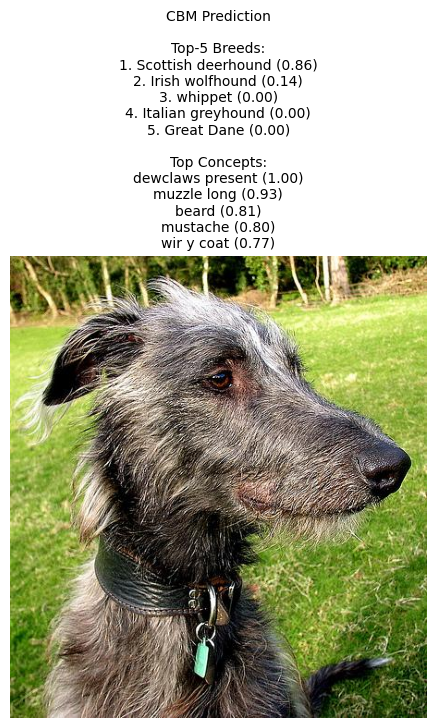

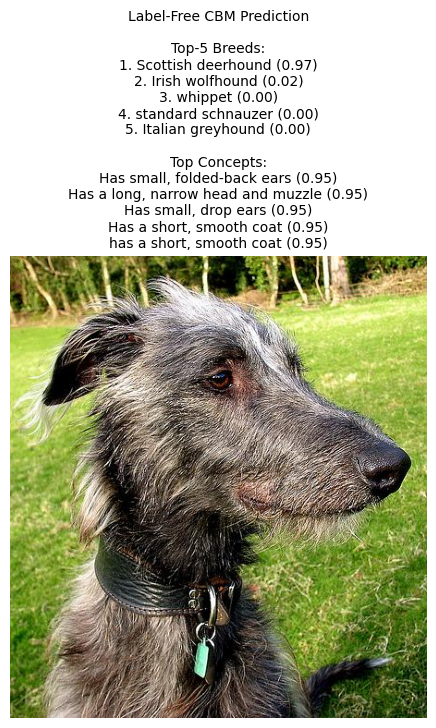

In [ ]:
# test image
random_idx = test_idx[8]
img_path = dataset.image_paths[random_idx]

# visualize cbm results
visualize_cbm_with_concepts(img_path, cbm_model, topk_classes=5, topk_concepts=5)

# visualize label free cbm results
visualize_label_free_cbm_with_concepts(img_path, proj_layer, classifier, text_features, \
                                       mean, std, active_idx, all_concepts, topk_classes=5, \
                                       topk_concepts=5)